## Background / Motivation

Chicago is often deemed one of the most dangerous cities in the United States, and people are typically concerned with this issue when visiting or living in the city. As the four of us are students at Northwestern—in close proximity to Chicago—we frequent the city ourselves, and have personally witnessed crimes committed. For example, on the Red Line, a common mode of transportation for many Chicago residents and tourists, there are many visible crimes that scare people away from using the subway. 
Therefore, we were interested in analyzing crimes in Chicago in order to see which types of crimes we should be more vigilant of, or where in Chicago we should practice extra caution. These analyses are crucial to our safety and the safety of others like us, who share similar experiences. Additionally, police inequality or inefficient allocation of resources in policing has been a prevalent issue in the United States recently, so we wanted to explore potential areas of disparity. 

*In a previous year, another group did a similar analysis on Chicago crime data for a different time frame. In the appendix, we speak to any overlap or differences we have with their project.*

## Problem statement 

1. Alyssa's question looks at how types of crime is distributed throughout the day. At various hours of the day, it is expected that crime characteristics will vary. We wanted to know which types of crimes are most common in the day-time vs. night-time, where crimes are commonly committed, and whether or not they are violent.  

2. Grace Chang's question examines theft, the most common type of crime, accounting for around 23% of total crimes, in further detail. We were interested in how theft was distributed across the various community areas of Chicago (e.g. The Loop), and how the population density of these areas relates to their respective theft rates. 

3. Grace Shao's question explores the most dangerous stations and community areas to ride the CTA in. We wanted to know the typical profiles of CTA crimes, specifically, where they are committed, whether they are committed on the train or platform, and which time of day to avoid certain stations. 

4. Paisley's question examines associations between the proportion of crimes that were arrested and the crime's location in the city of Chicago, particularly in regards to police districts. How does the arrest proportion vary depending on what part of the city the crime occurs in?

## Data sources

#### Primary Dataset:
To conduct our analysis, our primary dataset was Chicago crime data for 2022 as reported by the city of Chicago: https://data.cityofchicago.org/Public-Safety/Crimes-2022/9hwr-2zxp 

The data reports 239,043 observations of crimes in the city of Chicago (at the time of download, as this data is being updated to this day), and information about the crime such as its location, time/date, and whether or not the crime resulted in arrest. 

#### Supporting datasets include:
-  Chicago community areas by numeric code, population, area, and population density: https://en.wikipedia.org/wiki/Community_areas_in_Chicago 
    - Since the original dataset includes the numeric code of the community areas, to make our analysis more usable and readable, we merged the two datasets to include community area names. 

* IUCR codes https://data.cityofchicago.org/widgets/c7ck-438e 
    * Used in Alyssa’s analysis solely as reference to find violent crime type IUCR codes but not actually merged with main dataset.

- CTA stations coordinates: https://data.cityofchicago.org/Transportation/CTA-System-Information-List-of-L-Stops/8pix-ypme 
    - The latitude and longitude columms are used to find the nearest subway station of each crime.

* Police sentiment data via the city of Chicago: https://data.cityofchicago.org/Public-Safety/Police-Sentiment-Scores/28me-84fj/data
    * This dataset is a compilation of collected survey data about residents’ feeling towards police based on their responses to 4 questions: 1) rating the safety of their neighborhood, 2) rating how they feel the police in their neighborhood listen to concerns of local residents, 3) rating how well the police in their neighborhood treat local residents with respect, and 4) rating trust in their police. (Note: responses were scored on a scale of 1-10, and the data is compiled to multiply scores by 10 so an average rating of 60 in the dataset corresponds to an average score of 6)


## Stakeholders
Our primary purpose is to help stakeholders understand crime in the city of Chicago. This understanding helps general parties make better choices to promote public and personal safety.

* Chicago residents/visitors: Residents and visitors will benefit from our analysis by using our recommendations to more safely navigate the city and transit stations and make housing decisions. 

* Police force: For the police force, we hope our analysis can give them direction on how to better serve and satisfy communities across districts and determine where to focus resources to create a safer Chicago. 


## Data quality check / cleaning / preparation 

In [183]:
#| echo: false
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [184]:
#| echo: false
raw_crime_data = pd.read_csv("crimes_-_2022.csv")
raw_crime_data['Date'] = raw_crime_data['Date'].apply(pd.to_datetime)

In [185]:
#| echo: false
time_data = raw_crime_data.dropna(subset = ['Location Description'])
theft_data = raw_crime_data.loc[(raw_crime_data['Primary Type'] == 'THEFT'), :]
community_areas = pd.read_html('https://en.wikipedia.org/wiki/Community_areas_in_Chicago', match = 'Chicago community areas by number, population, and area')
community_areas = community_areas[0]
community_areas.columns = [col[0] for col in community_areas.columns]
community_areas.columns = ["No.", "Community Name", "Population", "Area (sqmi)", "Area (sqkm)", "Density (sqmi)", "Density (sqkm)"]

theft_data.loc[:,'Community Area'] = theft_data['Community Area'].apply(lambda x: f'{int(x):02d}' if isinstance(x, (int, str)) and str(x).isdigit() else x)
theft_data['Community Area'].value_counts().head(6) # Checking that the single digit codes were indeed converted to double digit format

theft_data.loc[:,'Community Area'] = theft_data['Community Area'].astype(str)
theft_community_data = theft_data.merge(community_areas, left_on = 'Community Area', right_on = 'No.', how = 'left')
theft_community_data['Community Name'] = theft_community_data['Community Name'].apply(lambda x: x.replace('(The) Loop[11]', 'The Loop'))

arrest_data = raw_crime_data.copy()
arrest_data['Side'] = arrest_data.District
arrest_data['Side'] = arrest_data['Side'].map({4: 'South', 5: 'South', 6: 'South', 7: 'South', 22: 'South', 31: 'South', \
                       11: "North", 14: 'North', 15: 'North', 16: 'North', 17: 'North', 19: 'North', 20: 'North',\
                       24: 'North', 25: 'North', 1: 'Central', 2: 'Central', 3: 'Central', 8: 'Central', \
                        9: 'Central', 10: 'Central', 12: 'Central', 13: 'Central', 18: 'Central'})

arrest_data = arrest_data.loc[arrest_data['District'] != 31, :]

# read sentiments data
sentiments = pd.read_csv('Police_Sentiment_Scores.csv')

# convert start date to datetime, subset only the values from 2022

sentiments['START_DATE'] = pd.to_datetime(sentiments['START_DATE'])
sentiments['START_DATE'] = sentiments['START_DATE'].map(lambda x: True if x.year == 2022 else False)
sentiments_2022 = sentiments.loc[sentiments['START_DATE'] == True, :]

# also subset only the general columns
sentiments_2022 = sentiments_2022.loc[:, ['DISTRICT', 'SAFETY', 'TRUST', 'T_RESPECT', 'T_LISTEN']]

crimesCTA = raw_crime_data.loc[raw_crime_data['Location Description'].apply(lambda x: 'CTA' in str(x) and 'CTA BUS' not in str(x) 
                                                            and 'CTA PARKING LOT / GARAGE / OTHER PROPERTY' not in str(x)), :]

# Drop NA location values (longitude and latitude)
numberRows = crimesCTA.shape[0]
numberLongitudeNA = crimesCTA['Longitude'].isna().sum()
numberLatitudeNA = crimesCTA['Latitude'].isna().sum()

crimesCTA.dropna(subset=['Longitude'], inplace=True)
crimesCTA.dropna(subset=['Latitude'], inplace=True)

# Add a column with the names of the community areas instead of just the number
communityAreas = pd.read_html('https://en.wikipedia.org/wiki/Community_areas_in_Chicago', match = 'Chicago community areas by number, population, and area')
communityAreas = communityAreas[0]
communityAreas.columns = [col[0] for col in communityAreas.columns]
communityAreas = communityAreas.iloc[:-1, [0,1]]
communityAreas.rename(columns={'No.': 'Community Area'}, inplace=True)
communityAreas.head()

crimesCTA['Community Area'] = crimesCTA['Community Area'].astype('int64')
communityAreas['Community Area'] = communityAreas['Community Area'].astype('int64')
crimesCTA = pd.merge(crimesCTA, communityAreas, on='Community Area', how='inner')
crimesCTA['Name'] = crimesCTA['Name'].apply(lambda x: x.replace('(The) Loop[11]', 'The Loop'))

In [186]:
#| echo: false
describeDataset = raw_crime_data.loc[:, ['Year', 'Latitude', 'Longitude']].describe()
hour = raw_crime_data.Date.dt.hour.describe().to_frame()
describeDataset['Hour'] = hour
sentimentsDescribe = sentiments_2022.describe().drop(columns = 'DISTRICT')
theft_describe = theft_community_data.loc[:, 'Density (sqkm)'].describe().to_frame()
describeDataset['Density (sqkm)'] = theft_describe
describeDataset = pd.concat([describeDataset, sentimentsDescribe], axis=1)
describeDataset.rename(columns={'SAFETY': 'Safety Score', 'TRUST': 'Trust Score', 'T_RESPECT': 'Respect Score', 'T_LISTEN': 'Listening Score', 'Density (sqkm)': 'Population Density'}, inplace=True)

### Continuous variables: Main and Supporting Datasets

In [187]:
#| echo: false
describeDataset

,Year,Latitude,Longitude,Hour,Population Density,Safety Score,Trust Score,Respect Score,Listening Score
count,239043.0,234936.000000,234936.000000,239043.000000,54845.000000,1164.000000,1164.000000,1164.000000,1164.000000
mean,2022.0,41.845596,-87.668599,12.317633,6984.499435,57.442328,57.462148,58.680120,56.244296
std,0.0,0.088833,0.061009,6.985090,3602.179700,5.389730,6.707499,7.096675,6.634690
min,2022.0,36.619446,-91.686566,0.000000,388.360000,33.980000,38.040000,39.310000,35.040000
25%,2022.0,41.769150,-87.710149,7.000000,4405.730000,54.137500,52.427500,53.540000,51.525000
50%,2022.0,41.862981,-87.661469,13.000000,6226.000000,57.470000,57.410000,58.420000,56.360000
75%,2022.0,41.909017,-87.626402,18.000000,9516.370000,61.380000,61.890000,63.667500,60.620000
max,2022.0,42.022548,-87.524532,23.000000,14863.580000,71.110000,77.100000,78.850000,75.630000


### Main Dataset Categorical Variables

In [188]:
#| echo: false

data = {
    'Name of Variable': ['IUCR', 
                         'Description', 
                         'Location Description',
                         'Arrest',
                         'District',
                         'Community Area',
                         'Community Name (From theft data)'],
    'Unique Values': [raw_crime_data['IUCR'].nunique(),
                                raw_crime_data['Description'].nunique(),
                                raw_crime_data['Location Description'].nunique(),
                                raw_crime_data['Arrest'].nunique(),
                                raw_crime_data['District'].nunique(),
                                raw_crime_data['Community Area'].nunique(),
                                theft_community_data['Community Name'].nunique()
                                ],
    'Missing Values': [raw_crime_data['IUCR'].isnull().sum(),
                                raw_crime_data['Description'].isnull().sum(),
                                raw_crime_data['Location Description'].isnull().sum(),
                                raw_crime_data['Arrest'].isnull().sum(),
                                raw_crime_data['District'].isnull().sum(),
                                raw_crime_data['Community Area'].isnull().sum(),
                                theft_community_data['Community Name'].isnull().sum()
                                ],
    'Most Common Value': ['Level: '+str(raw_crime_data['IUCR'].value_counts().reset_index().iloc[0, 0])+', Count: '+str(raw_crime_data['IUCR'].value_counts().reset_index().iloc[0, 1]),
                          'Level: '+str(raw_crime_data['Description'].value_counts().reset_index().iloc[0, 0])+', Count: '+str(raw_crime_data['Description'].value_counts().reset_index().iloc[0, 1]),
                          'Level: '+str(raw_crime_data['Location Description'].value_counts().reset_index().iloc[0, 0])+', Count: '+str(raw_crime_data['Location Description'].value_counts().reset_index().iloc[0, 1]),
                          'Level: '+str(raw_crime_data['Arrest'].value_counts().reset_index().iloc[0, 0])+', Count: '+str(raw_crime_data['Arrest'].value_counts().reset_index().iloc[0, 1]),
                          'Level: '+str(raw_crime_data['District'].value_counts().reset_index().iloc[0, 0])+', Count: '+str(raw_crime_data['District'].value_counts().reset_index().iloc[0, 1]),
                          'Level: '+str(raw_crime_data['Community Area'].value_counts().reset_index().iloc[0, 0])+', Count: '+str(raw_crime_data['Community Area'].value_counts().reset_index().iloc[0, 1]),
                          'Level: '+str(theft_community_data['Community Name'].reset_index().iloc[0, 0])+', Count: '+str(theft_community_data['Community Name'].value_counts().reset_index().iloc[0, 1])
                          ],
    'Second Most Common': ['Level: '+str(raw_crime_data['IUCR'].value_counts().reset_index().iloc[1, 0])+', Count: '+str(raw_crime_data['IUCR'].value_counts().reset_index().iloc[1, 1]),
                                          'Level: '+str(raw_crime_data['Description'].value_counts().reset_index().iloc[1, 0])+', Count: '+str(raw_crime_data['Description'].value_counts().reset_index().iloc[1, 1]),
                                          'Level: '+str(raw_crime_data['Location Description'].value_counts().reset_index().iloc[1, 0])+', Count: '+str(raw_crime_data['Location Description'].value_counts().reset_index().iloc[1, 1]),
                                          'Level: '+str(raw_crime_data['Arrest'].value_counts().reset_index().iloc[1, 0])+', Count: '+str(raw_crime_data['Arrest'].value_counts().reset_index().iloc[1, 1]),
                                          'Level: '+str(raw_crime_data['District'].value_counts().reset_index().iloc[1, 0])+', Count: '+str(raw_crime_data['District'].value_counts().reset_index().iloc[1, 1]),
                                          'Level: '+str(raw_crime_data['Community Area'].value_counts().reset_index().iloc[1, 0])+', Count: '+str(raw_crime_data['Community Area'].value_counts().reset_index().iloc[1, 1]),
                                          'Level: '+str(theft_community_data['Community Name'].reset_index().iloc[1, 0])+', Count: '+str(theft_community_data['Community Name'].value_counts().reset_index().iloc[1, 1])
                                           ],
    'Third Most Common': ['Level: '+str(raw_crime_data['IUCR'].value_counts().reset_index().iloc[2, 0])+', Count: '+str(raw_crime_data['IUCR'].value_counts().reset_index().iloc[2, 1]),
                                         'Level: '+str(raw_crime_data['Description'].value_counts().reset_index().iloc[2, 0])+', Count: '+str(raw_crime_data['Description'].value_counts().reset_index().iloc[2, 1]),
                                         'Level: '+str(raw_crime_data['Location Description'].value_counts().reset_index().iloc[2, 0])+', Count: '+str(raw_crime_data['Location Description'].value_counts().reset_index().iloc[2, 1]),
                                         '',
                                         'Level: '+str(raw_crime_data['District'].value_counts().reset_index().iloc[2, 0])+', Count: '+str(raw_crime_data['District'].value_counts().reset_index().iloc[2, 1]),
                                         'Level: '+str(raw_crime_data['Community Area'].value_counts().reset_index().iloc[2, 0])+', Count: '+str(raw_crime_data['Community Area'].value_counts().reset_index().iloc[2, 1]),
                                         'Level: '+str(theft_community_data['Community Name'].reset_index().iloc[2, 0])+', Count: '+str(theft_community_data['Community Name'].value_counts().reset_index().iloc[2, 1])
                                         ]
}
df = pd.DataFrame(data)
df

,Name of Variable,Unique Values,Missing Values,Most Common Value,Second Most Common,Third Most Common
0,IUCR,304,0,"Level: 0810, Count: 20096","Level: 0820, Count: 18863","Level: 0486, Count: 18679"
1,Description,284,0,"Level: SIMPLE, Count: 27207","Level: OVER $500, Count: 20096","Level: $500 AND UNDER, Count: 18863"
2,Location Description,134,881,"Level: STREET, Count: 67630","Level: APARTMENT, Count: 45596","Level: RESIDENCE, Count: 30470"
3,Arrest,2,0,"Level: False, Count: 211218","Level: True, Count: 27825",
4,District,23,0,"Level: 8, Count: 14811","Level: 6, Count: 14709","Level: 12, Count: 14353"
5,Community Area,77,0,"Level: 25, Count: 12251","Level: 8, Count: 10608","Level: 28, Count: 9496"
6,Community Name (From theft data),77,0,"Level: 0, Count: 4251","Level: 1, Count: 3464","Level: 2, Count: 3373"


### Individual Data Preparation & Cleaning

**Alyssa:** When preparing my data, I dropped the 881 missing values in Location Description. One of the key points of my analysis is checking to see if a crime is being committed in a public or private setting. Because of this, I could not use any observations where the location was not reported. I did not drop any other observations before I began using the dataset. Throughout my analysis, I sliced the data so that each time-frame I analyzed had their own dataframe and I used those new dataframes to continue my EDA. 

**Grace Chang:** When initially using the data, I had to subset the data such that only the observations with the Primary Type listed as "Theft" remained. For a more thorough analysis, considering that I did not use latitude or longitude in my analysis, I did not drop any missing values—most missing values were located in those two columns. I merged this dataset with one including information on the Community Area names, such that I could pair up the numeric codes of the Community Areas as listed in the raw dataset with their popularly known names. 
<br>In order to accomplish this, I had to clean the raw theft data so that the numeric codes were formatted in the same fashion as in the community area dataset. Upon retrieving the final, merged dataset, I also cleaned the observations so that the formatting of the community names were consistent.

**Grace Shao:** I began by subsetting the data to only include crimes occuring in the CTA station or in a CTA train. While I did not have to change any of the values in the dataset, I did remove the observations with NA values in the longitude or latitude. I needed to remove these observations to map each observation later in the analysis. Only around 1% of my data had NA values, so the removal did not have significant repercussions to my analysis. Additionally, I added the names of the community areas in order to enhance readibility and make it easier to make my graphs. The original code only included the numeric code of the community area for each observation, so I merged my data with a Wikipedia table that included matched numeric codes with community area names.

**Paisley:** For my analysis concerning arrests and police districts, I did not consider the 14 observations in district 31, as this district is split with area in both the North and South side and had so few observations (less that 1% of the data). Additionally, I added a new column for my analysis that binned the data by side based on its district referencing this source: https://news.wttw.com/sites/default/files/Map%20of%20Chicago%20Police%20Districts%20and%20Beats.pdf. For much of my analysis I only considered the top 12 crimes to ensure that one district with very few observations did not skew the data (note: in subsetting the top 10 crimes, I ommitted the crime type 'other offense' due to range of crimes within it). Lastly, for the police sentiments data that I worked with, I subsetted only the survey scores that were recorded in 2022 to match the crime dataset. Since the scores for safety, trust, respect, and listen were all very highly correlated with one another (correlation coefficients all > .9), I aggregated these scores by taking their mean in each district.

## Exploratory Data Analysis

In [189]:
#| echo: false
colors = ["#c77464", "#2396be", "#967aa0", "#ffc858", "#d8a2e7", "#89c388", "#e6a1c6", "#6c6bc9", "#82c1c4", "#d98c55"]
sns.set_palette(sns.color_palette(colors))

### Analysis 1
*By \<Alyssa Shou>*

For my question on how crime type varies throughout the day, I started by graphing a full distribution of the number of crimes per hour. Based on this line graph, I saw that there are peaks at 12 am and 12 pm, so I used these two hours as time frames to specifically analyze.

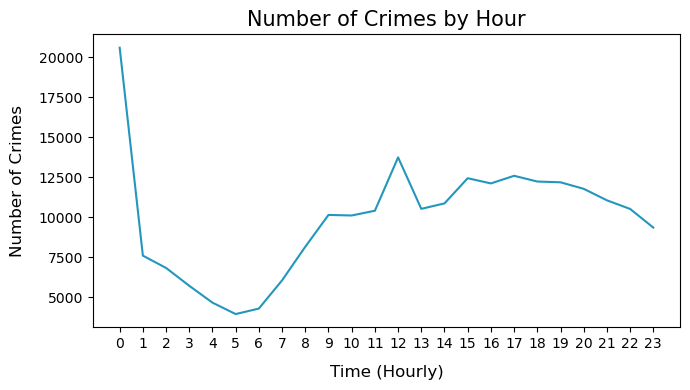

In [190]:
#| echo: false
# Round times down to nearest hour
time_data['hourly_time'] = time_data['Date'].dt.floor('H').dt.time

crime_counts = time_data['hourly_time'].value_counts().sort_index()
crime_counts = crime_counts.to_frame(name = 'Count').reset_index()

plt.rcParams["figure.figsize"] = [7, 4]
#plt.figure(figsize=(10, 6))
bx = sns.lineplot(x= crime_counts.index, y=crime_counts.Count, color = "#2396be")
step = len(crime_counts.index) // 24 
plt.xticks(range(0, len(crime_counts.index), step))
plt.xlabel('Time (Hourly)', fontsize = 12, labelpad=10)
plt.ylabel('Number of Crimes', fontsize = 12, labelpad=10)
plt.title('Number of Crimes by Hour', fontsize = 15)
plt.tight_layout()
plt.show()

I was also interested in analyzing rush hour time frames because there are more people commuting during those times and thus a higher potential for crime. Morning rush hour is considered 6-9 am and evening rush hour is considered 4-7 pm.

For each time frame, I have graphed the top 10 types of crimes and the top 10 locations at which crimes occur. These graphs are shown below.

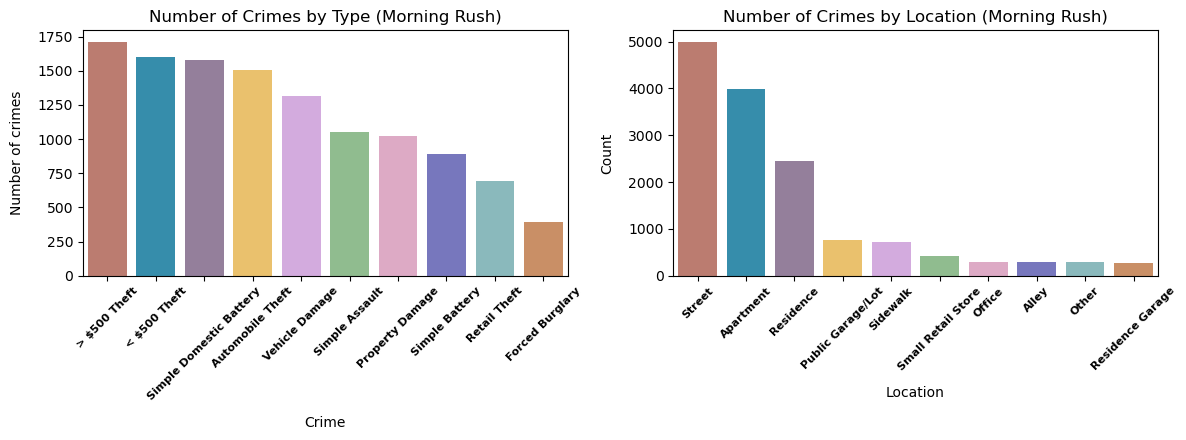

In [191]:
#| echo: false
morning_rush = time_data.loc[(time_data['Date'].dt.hour >= 6) & (time_data['Date'].dt.hour < 9)]
combination_mr = morning_rush.groupby(['Primary Type', 'Description']).size().reset_index(name='Count')
combination_mr = combination_mr.sort_values(by = 'Count', ascending = False).head(10)
combination_mr['Type'] = combination_mr['Primary Type'] + " " + combination_mr['Description']
mr_locations = morning_rush['Location Description'].value_counts().head(10)
locations_mr = mr_locations.to_frame(name = 'Count').reset_index()
plt.rcParams["figure.figsize"] = [5,3.5]

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))  # Adjust the figsize as needed

# Plotting the first graph on the first subplot (axes[0])
ax1 = sns.barplot(x=combination_mr.Type, y=combination_mr.Count, palette=colors, ax=axes[0])
ax1.set_xlabel('Crime', fontsize=10, labelpad=10)
ax1.set_xticklabels(labels=['> $500 Theft', '< $500 Theft', 'Simple Domestic Battery', 'Automobile Theft', 
                            'Vehicle Damage', 'Simple Assault', 'Property Damage', 'Simple Battery', 
                            'Retail Theft', 'Forced Burglary'], rotation=45, weight='bold', fontsize=8)
ax1.set_ylabel('Number of crimes', fontsize=10, labelpad=10)
ax1.set_title('Number of Crimes by Type (Morning Rush)', fontsize=12)
ax1.tick_params(axis='y', labelsize=10)
ax1.tick_params(axis='x', labelsize=8)

# Plotting the second graph on the second subplot (axes[1])
ax2 = sns.barplot(x=locations_mr.index, y=locations_mr.Count, palette=colors, ax=axes[1])
ax2.set_xlabel('Location', fontsize=10, labelpad=10)
ax2.set_xticklabels(labels=['Street', 'Apartment', 'Residence', 'Public Garage/Lot', 
                             'Sidewalk', 'Small Retail Store', 'Office', 'Alley', 'Other', 
                             'Residence Garage'], rotation=45, weight='bold', fontsize=8)
ax2.set_ylabel('Count', fontsize=10, labelpad=10)
ax2.set_title('Number of Crimes by Location (Morning Rush)', fontsize=12)
ax2.tick_params(axis='y', labelsize=10)
ax2.tick_params(axis='x', labelsize=8)

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

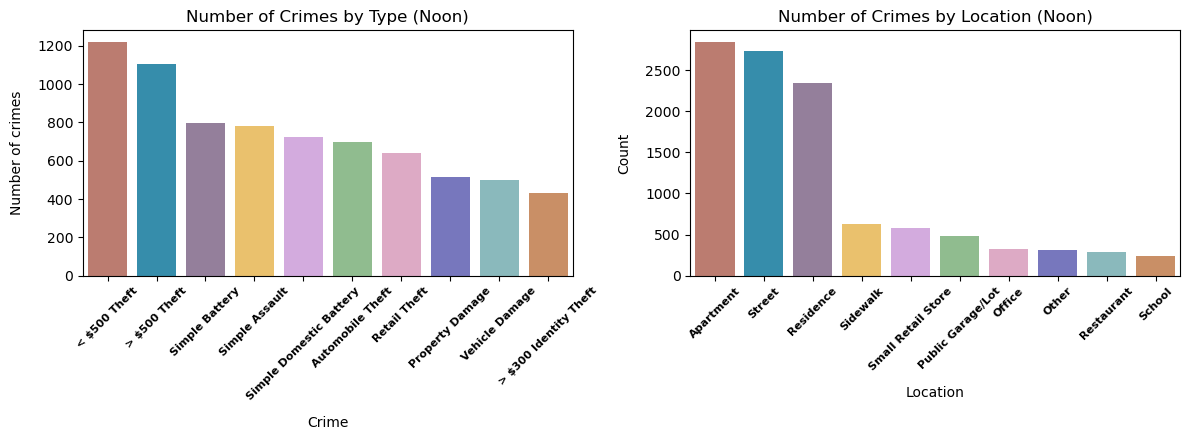

In [192]:
#| echo: false
noon = time_data.loc[time_data['Date'].dt.hour == 12]
combination_noon = noon.groupby(['Primary Type', 'Description']).size().reset_index(name='Count')
combination_noon = combination_noon.sort_values(by = 'Count', ascending = False).head(10)
combination_noon['Type'] = combination_noon['Primary Type'] + " " + combination_noon['Description']
noon_locations = noon['Location Description'].value_counts().head(10)
locations_noon = noon_locations.to_frame(name = 'Count').reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))  # Adjust the figsize as needed

# Plotting the first graph on the first subplot (axes[0])
ax1 = sns.barplot(x=combination_noon.Type, y=combination_noon.Count, palette=colors, ax=axes[0])
ax1.set_xlabel('Crime', fontsize=10, labelpad=10)
ax1.set_xticklabels(labels=['< $500 Theft', '> $500 Theft', 'Simple Battery', 'Simple Assault', 
                            'Simple Domestic Battery', 'Automobile Theft', 'Retail Theft', 'Property Damage', 
                            'Vehicle Damage', '> $300 Identity Theft'], rotation=45, weight='bold', fontsize=8)
ax1.set_ylabel('Number of crimes', fontsize=10, labelpad=10)
ax1.set_title('Number of Crimes by Type (Noon)', fontsize=12)
ax1.tick_params(axis='y', labelsize=10)
ax1.tick_params(axis='x', labelsize=8)

# Plotting the second graph on the second subplot (axes[1])
ax2 = sns.barplot(x=locations_noon.index, y=locations_noon.Count, palette=colors, ax=axes[1])
ax2.set_xlabel('Location', fontsize=10, labelpad=10)
ax2.set_xticklabels(labels=['Apartment', 'Street', 'Residence', 'Sidewalk', 
                            'Small Retail Store', 'Public Garage/Lot', 'Office', 'Other', 
                            'Restaurant', 'School'], rotation=45, weight='bold', fontsize=8)
ax2.set_ylabel('Count', fontsize=10, labelpad=10)
ax2.set_title('Number of Crimes by Location (Noon)', fontsize=12)
ax2.tick_params(axis='y', labelsize=10)
ax2.tick_params(axis='x', labelsize=8)

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

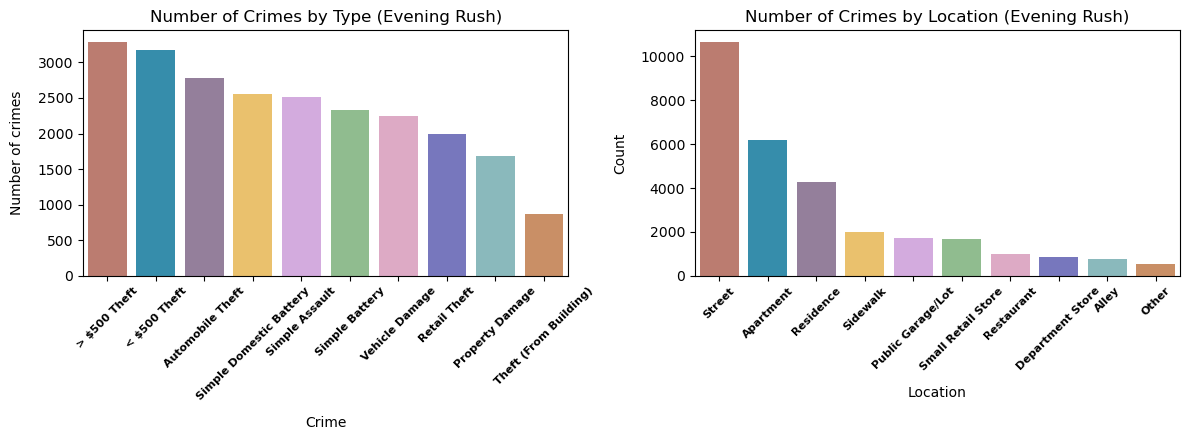

In [193]:
#| echo: false
evening_rush = time_data.loc[(time_data['Date'].dt.hour >= 16) & (time_data['Date'].dt.hour < 19)]
combination_er = evening_rush.groupby(['Primary Type', 'Description']).size().reset_index(name='Count')
combination_er = combination_er.sort_values(by = 'Count', ascending = False).head(10)
combination_er['Type'] = combination_er['Primary Type'] + " " + combination_er['Description']
er_locations = evening_rush['Location Description'].value_counts().head(10)
locations_er = er_locations.to_frame(name = 'Count').reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))  # Adjust the figsize as needed

# Plotting the first graph on the first subplot (axes[0])
ax1 = sns.barplot(x=combination_er.Type, y=combination_er.Count, palette=colors, ax=axes[0])
ax1.set_xlabel('Crime', fontsize=10, labelpad=10)
ax1.set_xticklabels(labels=['> $500 Theft', '< $500 Theft', 'Automobile Theft', 'Simple Domestic Battery',
                             'Simple Assault', 'Simple Battery', 'Vehicle Damage', 
                             'Retail Theft', 'Property Damage', 'Theft (From Building)'], 
                     rotation=45, weight='bold', fontsize=8)
ax1.set_ylabel('Number of crimes', fontsize=10, labelpad=10)
ax1.set_title('Number of Crimes by Type (Evening Rush)', fontsize=12)
ax1.tick_params(axis='y', labelsize=10)
ax1.tick_params(axis='x', labelsize=8)

# Plotting the second graph on the second subplot (axes[1])
ax2 = sns.barplot(x=locations_er.index, y=locations_er.Count, palette=colors, ax=axes[1])
ax2.set_xlabel('Location', fontsize=10, labelpad=10)
ax2.set_xticklabels(labels=['Street', 'Apartment', 'Residence', 'Sidewalk', 'Public Garage/Lot', 
                             'Small Retail Store', 'Restaurant', 'Department Store', 'Alley', 'Other'], 
                     rotation=45, weight='bold', fontsize=8)
ax2.set_ylabel('Count', fontsize=10, labelpad=10)
ax2.set_title('Number of Crimes by Location (Evening Rush)', fontsize=12)
ax2.tick_params(axis='y', labelsize=10)
ax2.tick_params(axis='x', labelsize=8)

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

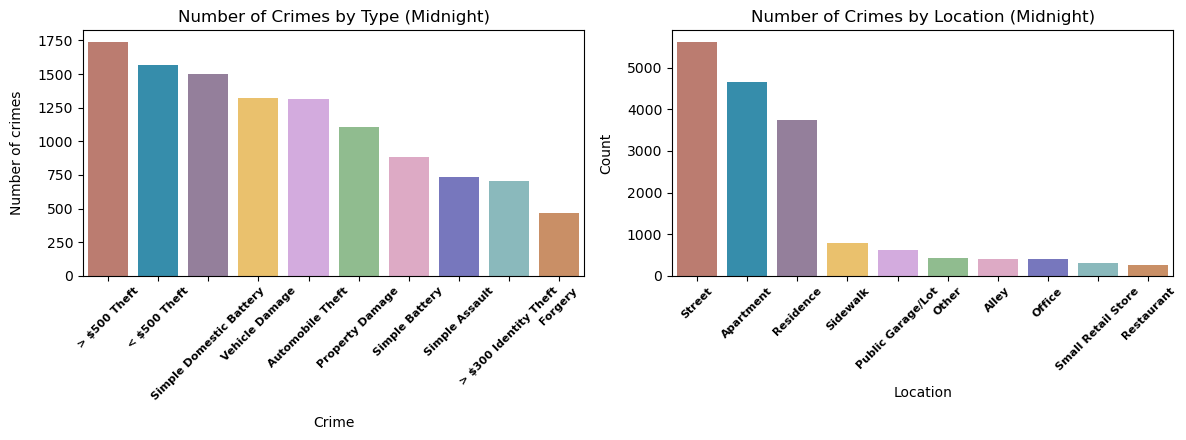

In [194]:
#| echo: false
midnight = time_data.loc[time_data['Date'].dt.hour == 0]
combination_midnight = midnight.groupby(['Primary Type', 'Description']).size().reset_index(name='Count')
combination_midnight = combination_midnight.sort_values(by = 'Count', ascending = False).head(10)
combination_midnight['Type'] = combination_midnight['Primary Type'] + " " + combination_midnight['Description']
midnight_locations = midnight['Location Description'].value_counts().head(10)
locations_midnight = midnight_locations.to_frame(name = 'Count').reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))  # Adjust the figsize as needed

# Plotting the first graph on the first subplot (axes[0])
ax1 = sns.barplot(x=combination_midnight.Type, y=combination_midnight.Count, palette=colors, ax=axes[0])
ax1.set_xlabel('Crime', fontsize=10, labelpad=10)
ax1.set_xticklabels(labels=['> $500 Theft', '< $500 Theft', 'Simple Domestic Battery', 'Vehicle Damage', 
                             'Automobile Theft', 'Property Damage', 'Simple Battery', 'Simple Assault', 
                             '> $300 Identity Theft', 'Forgery'], rotation=45, weight='bold', fontsize=8)
ax1.set_ylabel('Number of crimes', fontsize=10, labelpad=10)
ax1.set_title('Number of Crimes by Type (Midnight)', fontsize=12)
ax1.tick_params(axis='y', labelsize=10)
ax1.tick_params(axis='x', labelsize=8)

# Plotting the second graph on the second subplot (axes[1])
ax2 = sns.barplot(x=locations_midnight.index, y=locations_midnight.Count, palette=colors, ax=axes[1])
ax2.set_xlabel('Location', fontsize=10, labelpad=10)
ax2.set_xticklabels(labels=['Street', 'Apartment', 'Residence', 'Sidewalk', 
                            'Public Garage/Lot', 'Other', 'Alley', 'Office', 
                            'Small Retail Store', 'Restaurant'], rotation=45, weight='bold', fontsize=8)
ax2.set_ylabel('Count', fontsize=10, labelpad=10)
ax2.set_title('Number of Crimes by Location (Midnight)', fontsize=12)
ax2.tick_params(axis='y', labelsize=10)
ax2.tick_params(axis='x', labelsize=8)

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

After finding the top 10 types of crime at each time, we can observe that the top crimes are very similar throughout the day. On that front, I did not see much variation, but there are some minor differences.

- Midnight is the only time where retail theft is not in the top 10
- Forced burglary is a top 10 crime at morning rush
- Theft from building is a top 10 crime during evening rush hour
- Comparatively, vehicle related crimes (ie. damage & theft) are less common at noon than other times

Finding the top 10 crimes at each time was the first thing I tried since it seemed like the most logical first step in the analysis. I did not anticipate or run into any problems at this step. We can see that even the differences above are not that significant and 9/10 crimes between each time frame overlap. Each of these differences can be explained with common sense logic. For example, forced burglary may be more common during morning rush hour because burglars are aware that houses will be empty as people leave to commute to work.

**Public vs. Private Crime Rates** <br>
After looking at the top 10 types of crimes and observing no egregious variation, my next step was to analyze crime locations. The top three locations are the same for every time frame: Street, Apartment, Residence. After those three locations, the rest of the locations are clearly less common. I then took the total number of crimes committed among the top 10 crimes and found the proportion of them that were committed in public areas such as street, sidewalk, public garage. etc.

-  Morning Rush: 49.6%
-  Noon: 45.9%
-  Evening Rush: 62.9% 
-  Midnight: 46.4%

Crimes are the most public during evening rush hour, but about the same degree of publicity in the other three time frames. I believe exploring crime location is important since these are general locations that stakeholders should avoid during specific times. Publicity rate is a successful way to measure safety because public crimes lend themselves to being the most common crimes and are often impulsive actions such as assault/battery and theft.

At first, I tried to keep all the time frames in a side-by-side barplot to keep the visualization cleaner and more brief. I quickly realized that this would not work because the top 10 locations for crimes at different times throughout the day would not be the same. Therefore, there would be parts of the graph with empty or very low bars for locations that are not included in the top 10 locations for all times. This would be misleading to stakeholders so I chose to slice the data and create separate bar graphs for clarity and organization. 

**Rate of Violent Crimes**<br>
Stakeholders are often concerned about crime violence. A common stereotype of Chicago is that we are a very dangerous city and many people unconsciously think of violent crimes when they think of crime in general. Because of this, I created a new column in the dataset that labeled each observation as violent or non-violent (see code file). Violent crimes might include: armed robbery, aggravated domestic battery, homicide first degree murder. Non-violent crimes include: theft pocket-picking, forgery, unlawful entry/trespassing, etc. Below are the percent of crimes in each time frame that are labeled as violent according to Illinois Uniform Crime Report (IUCR) codes. Then I found the percentage of reported crime in each time frame that was labeled violent.

- Morning Rush: 23.69%
- Noon: 18.88%
- Evening Rush: 23.93%
- Midnight: 21.88%

Unfortunately these rates are not negligible and crime does get violent in about 1/5 of data across all times of day. In the recommendations, I will provide action items for stakeholders based off this analysis.

*Note: the previous year's project group also analyzed crime at various hours of day. See Appendix A2 for more information*

### Analysis 2
*By \<Grace Chang>*

Since I am conducting research on theft, I subset the data so that only data with the Primary Type “Theft” remained; therefore, I could perform my subsequent analyses on only the theft data. I firstly wanted to see how the types of theft varied across the seventy-seven government-delineated Chicago community areas. In order to perform this analysis, I looked for the top twelve community areas with the highest number of observations of theft crimes, and subset the data such that only the data for these twelve areas remained. I focused on only these twelve observations because I wanted to visualize for stakeholders which areas they should pay particular attention to in terms of how often theft crimes are observed there, and how types of theft crimes compare across those twelve areas. 
<br>In order to visualize these statistics, I decided on using a stacked bar-plot. Originally, I tried to use a series of line plots—one plot for each community area in the top twelve, featuring the number of thefts of a given type of theft during each month of the year—via the Seaborn FacetGrid method. This did not work as there was a drastic difference between the number of occurrences in certain categories of theft for some community areas during most of the months. As a result, the scale of the plots within the FacetGrid, while they were consistent, did not match up well with the scale of the lines plotted, and the visualization was difficult to view and interpret. The stacked bar-plot removed the month factor, but I realized by attempting the FacetGrid that the month did not matter much. The stacked bar-plot makes it easy to see the proportions of the various theft types and visually compares the frequencies for the different community areas.

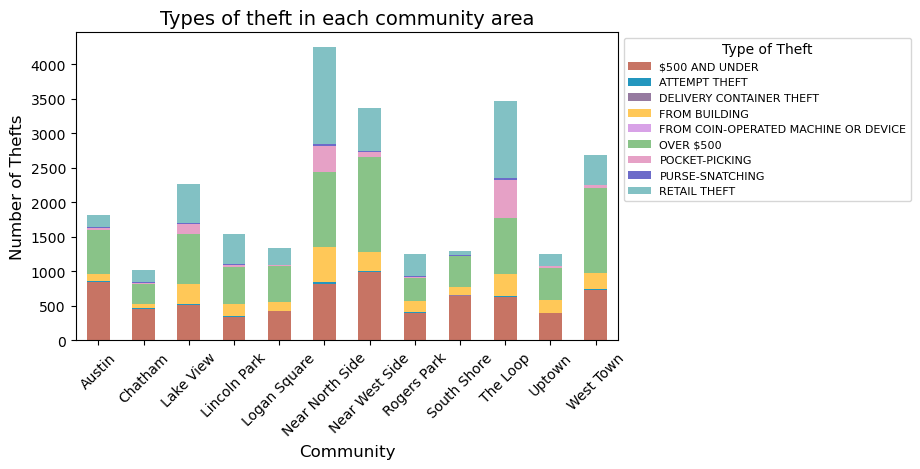

In [195]:
#| echo: false

# Finding the top 12 community areas that experience the most theft
plt.rcdefaults()
top_12_community_areas = theft_community_data['Community Name'].value_counts().head(12)
top_12_areas_list = top_12_community_areas.index.to_list()
top_12_areas_data = theft_community_data[theft_community_data['Community Name'].isin(top_12_areas_list)]

theft_type = pd.crosstab(top_12_areas_data['Community Name'], top_12_areas_data['Description'])

# Color palette
colors = ["#c77464", "#2396be", "#967aa0", "#ffc858", "#d8a2e7", "#89c388", "#e6a1c6", "#6c6bc9", "#82c1c4", "#d98c55"]
sns.set_palette(sns.color_palette(colors))

# Stacked barplot
ax = theft_type.plot.bar(stacked = True, ylabel = 'Number of Thefts', figsize=(7, 4), xlabel = 'Community')
ax.tick_params(axis = 'both', labelsize = 10)
ax.tick_params(axis = 'x', labelrotation = 45)

# Labels for the plot
ax.legend(title = 'Type of Theft', fontsize=8, title_fontsize=10, bbox_to_anchor = (1, 1, 0, 0))
ax.set_xlabel('Community', fontsize=12)
ax.set_ylabel('Number of Thefts', fontsize=12)
ax.set_title('Types of theft in each community area', fontsize=14);

Based on this plot, I noticed that theft over 500 dollars dominates theft under 500 dollars in most of the districts, with a notable difference in the ‘West Town’ and ‘Near West Side’ areas, showing that theft of greater financial value is more common than that of less value—this is further supported by the percentages of each type of overall theft, where theft over 500 dollars accounts for 33%, and theft under 500 dollars around 28%. While this is not a significant difference, I concluded that financial theft in general is by far the most common type of theft. The plot also exhibits this trend, where theft of monetary assets account for the greatest proportion of thefts, and retail theft also being common. One surprising observation from this plot is that pick-pocketing only makes up a small part of thefts across the twelve community areas compared to retail theft and financial theft.
<br>Finally, I observed that the four areas with the most theft occurrences were concentrated in the same area—The Loop, Near North Side, Near West Side, and West Town border each other, and this region is also often described as downtown Chicago by visitors and residents. This observation implies that people should be particularly wary in these areas, especially seeing as they are popular areas to live and visit. Based on this context, I further questioned whether there was a relationship between the population density of a community area and the number of thefts in that area. In order to attack this problem, I created a dataset via merging that included the community area names, their corresponding numbers of thefts, and their population densities. I then utilized this dataset to plot a linear regression relating population density and number of thefts.

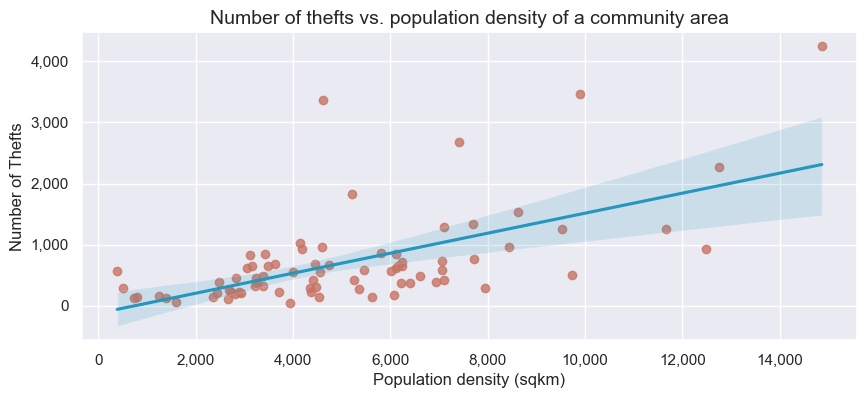

In [196]:
#| echo: false

# Correlate population density with crime
theft_counts_areas = pd.DataFrame(theft_community_data['Community Name'].value_counts())
theft_counts_areas = theft_counts_areas.reset_index()
theft_counts_areas.columns = ["Community Name", "Number of Thefts"]

community_areas['Community Name'] = community_areas['Community Name'].apply(lambda x:x.replace('(The) Loop[11]', 'The Loop'))

theft_counts_areas['Community Name'] = theft_counts_areas['Community Name'].astype(str)
theft_with_density = theft_counts_areas.merge(community_areas, left_on = 'Community Name', right_on = 'Community Name', how = 'left')

plt.rcdefaults()
plt.figure(figsize=(10, 4))
sns.set(font_scale = 1.5)
ax = sns.regplot(x = 'Density (sqkm)', y = 'Number of Thefts', data = theft_with_density, scatter_kws = {'color':'#c87464'}, line_kws = {'color':'#2596be'})

ax.set_title('Number of thefts vs. population density of a community area', fontsize=14)
ax.xaxis.set_major_formatter('{x:,.0f}')
ax.yaxis.set_major_formatter('{x:,.0f}')
ax.tick_params(axis = 'both', labelsize = 11)
ax.set_xlabel('Population density (sqkm)', fontsize=12)
ax.set_ylabel('Number of Thefts', fontsize=12);

In [197]:
#| echo: false

print('Community Areas Ranked by Population Density','\n',\
      (theft_with_density.sort_values(by = 'Density (sqkm)', ascending = False))[['Community Name', 'Density (sqkm)']].head(12),sep = '')

Community Areas Ranked by Population Density
     Community Name  Density (sqkm)
0   Near North Side        14863.58
4         Lake View        12752.44
15        Edgewater        12491.89
9       Rogers Park        11672.81
1          The Loop         9897.73
38      Albany Park         9732.13
10           Uptown         9516.37
6      Lincoln Park         8612.96
12       West Ridge         8435.36
55          Hermosa         7940.46
20   Belmont Cragin         7713.71
7      Logan Square         7707.48


It is important to see that while there is a general positive correlation, out of the top four community areas of interest that I discovered as exhibiting the highest numbers of theft, only two of them fall under the top twelve most population dense areas. I formulated this observation by comparing the top four with the top twelve because the top four community areas of interest were originally extracted from the top twelve community areas with the most theft overall. This observation implies that there are likely many extraneous variables in play affecting the number of thefts aside from simply the population density of an area, but based on the trend, we can assume that population density is still a significant independent variable. Seeing as the Near North Side (rank 1 in population density) and The Loop (rank 5 in population density) areas are much more dense than the West Town and Near West Side areas, but border these two areas to the right, a potential explanation could also be that there are many people who travel between these areas, and with them comes a spill-over of theft crimes into these two less population dense areas. 

### Analysis 3
*By \<Grace Shao>*

I began by investigating the location of CTA crimes. In order for Chicagoans to know which locations they should avoid, the community area with the most crime is important information. I found the 10 community areas with the highest number of crimes, and graphed them below in descending order. The Loop has the most crime by far, outnumbering other community areas by a significant amount. Compared to the #2 most dangerous station, The Loop still had more than 4x the amount of crime.

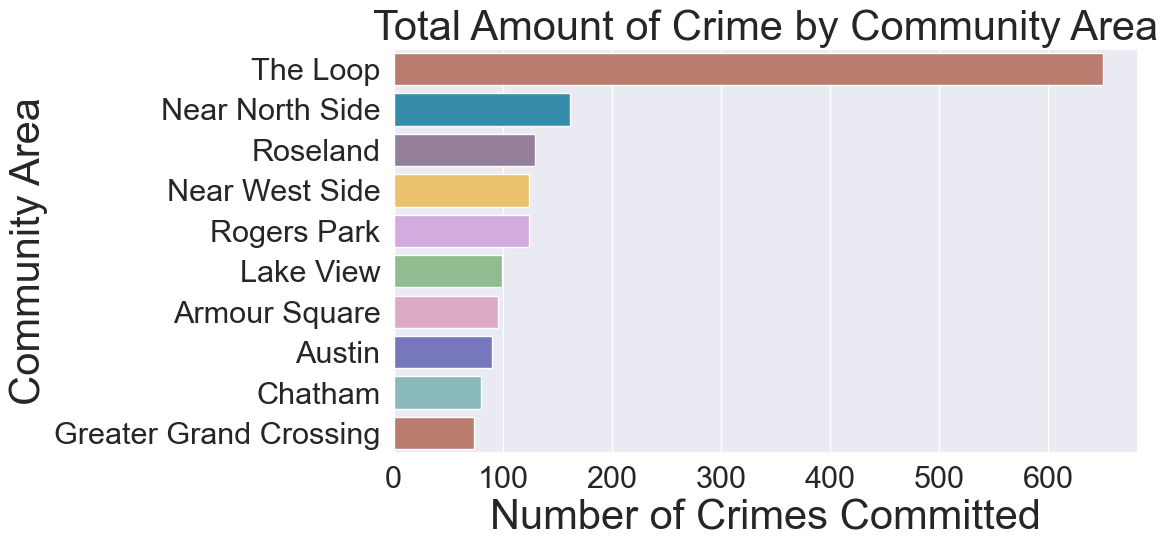

In [198]:
#| echo: false
# Plot

plt.rcParams["figure.figsize"] = [12.00, 6]
plt.rcParams["figure.autolayout"] = True

my_palette = ["#881177", "#aa3355", "#cc6666", "#ee9944", "#eedd00", "#99dd55", "#44dd88", "#22ccbb", "#00bbcc", "#0099cc", "#3366bb", "#663399"]
grace_palette = ["#c77464", "#2396be", "#967aa0", "#ffc858", "#d8a2e7", "#89c388", "#e6a1c6", "#6c6bc9", "#82c1c4"]

# List of top 10 most dangerous areas
top10 = crimesCTA['Name'].value_counts().head(10).to_frame()
top10Areas = top10.index.tolist()

# Top 10 most dangerous areas - all observations
top10Data = crimesCTA.loc[crimesCTA['Community Area'].apply(lambda x: x in top10Areas), :]

sns.set(font_scale=2)

g = sns.barplot(data=top10, x=top10['Name'], y = top10.index, label="Number of Crimes", orient='h', palette = grace_palette)

# Set label for x-axis 
plt.xlabel("Number of Crimes Committed" , size = 30) 
  
# Set label for y-axis 
plt.ylabel("Community Area" , size = 30) 
  
# Set title for figure 
plt.title( "Total Amount of Crime by Community Area" , size = 30) 
  
# Display figure 
plt.show() 

This graph matches the map of CTA crimes as shown below. I wanted to create this map to visualize where crimes were happening and highlight that The Loop had a very high number of crimes, shown with the high density of points in that area. With this question, I did not anticipate that I would have to make many changes to make the map more readable. I changed the color scale to correspond with the community area, decreased opacity, and increased the zoom to focus on The Loop. This process took a lot of trial and error, especially since plotly was a new library that I had never used before.

In [1]:
#| echo: false
import plotly.express as px

import plotly.io as pio
pio.renderers.default = "notebook"

fig = px.scatter_mapbox(crimesCTA, 
                        lat="Latitude", 
                        lon="Longitude", 
                        hover_name="ID", 
                        color="Community Area",
                        color_continuous_scale=px.colors.sequential.Rainbow,
                        zoom=11, 
                        height=200,
                        opacity=0.5,
                        center=dict(lat=41.8725, lon=-87.6413),
                        width=400).update_traces(marker={"size": 10})

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show("notebook")

NameError: name 'crimesCTA' is not defined

Since The Loop represented such a large portion of the crimes committed and is an extremely popular area of Chicago (The Bean, Art Institute, and River Walk are all located there), I wanted to do further analysis on it. Subsetting the data to include only The Loop, I found the most common crimes occurring on CTA stations within that community area. For the top 6 crime types, I found that 3 were theft related and 3 were more physical and violent. Simple battery was the most common crime overall, while pickpocketing was the second most common crime.

I thought it was interesting that theft related crimes were much more likely to happen on the train. However, when looking at physical crimes, a significant proportion happened on the platform. Compared to theft, a higher proportion happened on the platform.

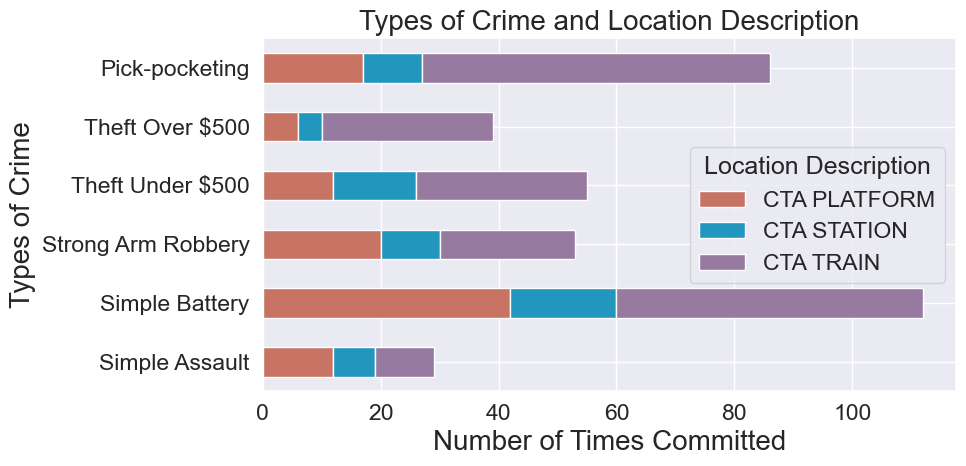

In [200]:
#| echo: false

plt.rcParams["figure.figsize"] = [10.00, 5]
plt.rcParams["figure.autolayout"] = True

area32 = crimesCTA.loc[crimesCTA['Name'].apply(lambda x: 'The Loop' in str(x)), :]
area32['Combined Description'] = area32["Primary Type"] + [' '] + area32["Description"]
area32Crime = area32['Combined Description'].value_counts().head(6).to_frame()
crimeTypes = area32Crime.index.to_list()

top6Crimes = area32.loc[area32['Combined Description'].apply(lambda x: x in crimeTypes), :]
top6Crimes['Combined Description'].value_counts()

trainPlatform = top6Crimes.loc[:, ['Location Description', 'Combined Description']]
trainPlatformCross = pd.crosstab(top6Crimes['Combined Description'],
                      top6Crimes['Location Description'])

# Plot
sns.set_palette("husl")
sns.set(font_scale=1.5)
g = trainPlatformCross.plot.barh(stacked = True, ylabel = 'Frequency of Crime', xlabel = 'Location of Crime', color = grace_palette)
g.set_yticklabels(['Simple Assault','Simple Battery','Strong Arm Robbery','Theft Under $500','Theft Over $500','Pick-pocketing'])
# Set label for x-axis 

plt.xlabel("Number of Times Committed", size = 20) 
  
# Set label for y-axis 
plt.ylabel("Types of Crime", size = 20) 
  
# Set title for figure 
plt.title( "Types of Crime and Location Description" , size = 20) 
  
# Display figure 
plt.show() 

plt.rcdefaults()

Now that I had established The Loop as the most dangerous community area, I wanted to also pinpoint the most dangerous stations. During my data analysis, I ran into a problem. The dataset did not include which station the crime was committed at – only the longitude and latitude.  I had anticipated that the crimes might be clustered and easy to identify on a map, but I found that in areas with many stations it was very difficult to visually identify which station the crime belonged to. I decided instead to import a list of the CTA stations and their coordinates.

For each crime, I found the closest station by longitude and latitude using the Haversine formula, which is recommended for coordinates calculations because it simulates distance on a sphere$^{1}$. I then found and created a graph of the top 3 most dangerous stations.

1. “Haversine Formula to Find Distance between Two Points on a Sphere.” GeeksforGeeks, GeeksforGeeks, 5 Sept. 2022, www.geeksforgeeks.org/haversine-formula-to-find-distance-between-two-points-on-a-sphere/. 

In [201]:
#| echo: false

stations = pd.read_csv('CTA_SYSTEM_INFO.csv')
stationsCoords = stations.loc[:, ['STOP_ID', 'STOP_NAME', 'STATION_DESCRIPTIVE_NAME', 'MAP_ID', 'Latitude', 'Longitude']]

crimesCTA_Stations = crimesCTA.copy()

# Using the Haversine formula, calculate closest subway station (longitude and latitude)
from math import cos, asin, sqrt

def distance(lat_crime, long_crime):
    distance_list = []
    p = 0.017453292519943295
    for i in range(stationsCoords.shape[0]):
        
        # Hav value = result of the Haversine Formula
        hav = 0.5 - cos((lat_crime-stationsCoords['Latitude'][i])*p)/2 + cos(stationsCoords['Latitude'][i]*p)*cos(lat_crime*p) * (1-cos((long_crime-stationsCoords['Longitude'][i])*p)) / 2
        
        # Append these distances into the list
        distance_list.append(12742 * asin(sqrt(hav)))
        
    minimum = distance_list.index(min(distance_list))
    stationName = stations['STATION_NAME'][minimum]
    return stationName

station_list = []
for i in range(crimesCTA_Stations.shape[0]):
    if pd.isna(crimesCTA_Stations['Latitude'].iloc[i]) or pd.isna(crimesCTA_Stations['Longitude'].iloc[i]):
        station_list.append('NaN')
    else:
        station = distance(crimesCTA_Stations['Latitude'].iloc[i], crimesCTA_Stations['Longitude'].iloc[i])
        station_list.append(station)

station_list_frame = pd.DataFrame(station_list)
crimesCTA_withStation = crimesCTA_Stations.copy().reset_index()
crimesCTA_withStation['Station'] = station_list_frame
top3Stations = crimesCTA_withStation['Station'].value_counts().head(3).to_frame()

FileNotFoundError: [Errno 2] No such file or directory: 'CTA_SYSTEM_INFO.csv'

In [ ]:
#| echo: false
g = sns.barplot(data=top3Stations, x='Station', y=top3Stations.index, label="Number of Crimes", palette = grace_palette)

plt.rcParams["figure.figsize"] = [6, 2]
plt.rcParams["figure.autolayout"] = True

# Set label for x-axis 
plt.xlabel("Number of Crimes Committed" , size = 15) 
  
# Set label for y-axis 
plt.ylabel("Station Name" , size = 15) 
  
# Set title for figure 
plt.title( "Top 3 Stations With the Most Crime" , size = 20) 
  
# Display figure 
plt.tight_layout()
plt.show() 

In [ ]:
#| echo: false

import plotly.io as pio
pio.renderers.default = "notebook"

conditions = (
    crimesCTA_withStation['Station'].isin(['Jackson', 'Roosevelt', '95th/Dan Ryan'])
)

top3Stations_Data = crimesCTA_withStation[conditions]

color_scale = [(0, 'orange'), (1,'red')]

fig = px.scatter_mapbox(top3Stations_Data, 
                        lat="Latitude", 
                        lon="Longitude", 
                        hover_name="ID", 
                        color="Community Area",
                        color_continuous_scale=color_scale,
                        zoom=9.7, 
                        height=280,
                        center=dict(lat=41.7955, lon=-87.6413),
                        width=400).update_traces(marker={"size": 10})

fig.update_layout(coloraxis_showscale=False)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show("notebook")

The map below shows the mapped out crimes for each of the top 3 most dangerous stations. Two of these stations existed in The Loop, and the other was more South. All three were Red line stations. 

While knowing the top 3 most dangerous stations is important, I also wanted to know the time of day where most crimes occur. This gives people more information in case they are traveling through these stations. I found that crimes happen most just after midnight around 2 AM and during rush hour. This trend held true for all 3 stations.

In [ ]:
#| echo: false
import datetime

# Convert Timestamp to string format using strftime
top3Stations_Data['Date_String'] = top3Stations_Data['Date'].dt.strftime('%m/%d/%Y %I:%M:%S %p')

# Apply strptime to convert string back to datetime and extract hour
top3Stations_Data['Hour'] = top3Stations_Data['Date_String'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p')).dt.hour

# Drop the intermediate column 'Date_String' if not needed
top3Stations_Data.drop(columns=['Date_String'], inplace=True)

# Set the figure size
sns.set(rc={'figure.figsize': (10, 2)})

# Create the KDE plot using displot and store the plot object
plot = sns.displot(data=top3Stations_Data, x='Hour', kind='kde', col='Station')

# Set label for x-axis and y-axis
plot.set_axis_labels("Hour", "Frequency", fontsize = 30)
plot.set(xlim=(0, 24))

plt.xticks(range(0, 25, 3), labels=[str(i) for i in range(0, 25, 3)])
plot.set_xticklabels(fontsize=24)
plot.set_titles(fontsize=30)  
plt.subplots_adjust(hspace=0, wspace=0.2)
plt.show()

Lastly, I wanted to explore just how much more dangerous Roosevelt, the most crime ridden station, was than the average station. This would be important for my recommendations to stakeholders to illustrate why safety is important around The Loop.

In [ ]:
#| echo: false

totalCrimes = crimesCTA_withStation['Station'].value_counts().sum()
stationsWithoutRoosevelt = crimesCTA_withStation['Station'].nunique() - 1

rooseveltCrimeNumber = 194
averageCrimePerStation = (totalCrimes - rooseveltCrimeNumber) / stationsWithoutRoosevelt

timesMoreDangerous = rooseveltCrimeNumber / averageCrimePerStation
print("The Roosevelt station is", timesMoreDangerous, "times more dangerous than the average station.")

### Analysis 4
*By \<Paisley Lucier>*

For my analysis I explored the associations between proportion of committed crimes that resulted in arrest and the crime loaction. Since arrest proportion is a critical metric for policing, I used police district to describe location to ensure applicability for stakeholders. Particularly, I also wanted to consider a police district's sentiment score rating to see if there were associations between a district's sentiment score and their arrest proportion. As 'Arrest' is a boolean value, I had to find representative and effective ways to bin the data, before landing on binning police districts by side of Chicago. Ultimately, within my analysis I both look at general trends in location by considering the 'side' of districts, which still maintaining the specificity of district for other analyses in order to offer recommendations for police in specific districts. 

Firstly, I generally looked at the proportion of observations that resulted in arrest by each side of Chicago, as well as the average sentiment score by side. 

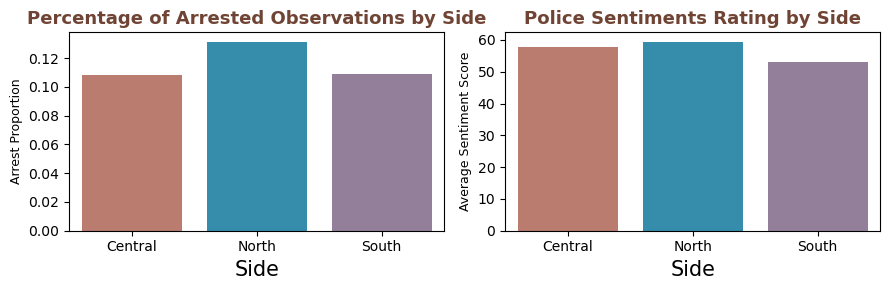

In [202]:
#| echo: false

plt.rcParams["figure.figsize"] = [9, 3]
plt.rcParams["figure.autolayout"] = True
colors = ["#c77464", "#2396be", "#967aa0", "#ffc858", "#d8a2e7", "#89c388", "#e6a1c6", "#6c6bc9", "#82c1c4", "#d98c55"]

sns.set_palette(sns.color_palette(colors))

f, axes = plt.subplots(1, 2)

grouped_sides = arrest_data.groupby(['Side'])
grouped_sides_m = grouped_sides.mean()

# -- next plot prep

# Group by district
sentiments_2022_m = sentiments_2022.groupby(['DISTRICT']).mean()
sentiments_2022_m = sentiments_2022_m.reset_index()

# Add side column
sentiments_2022_m['Side'] = sentiments_2022_m['DISTRICT']
sentiments_2022_m['Side'] = sentiments_2022_m['Side'].map({4: 'South', 5: 'South', 6: 'South', 7: 'South', 22: 'South', 31: 'South', \
                       11: "North", 14: 'North', 15: 'North', 16: 'North', 17: 'North', 19: 'North', 20: 'North',\
                       24: 'North', 25: 'North', 1: 'Central', 2: 'Central', 3: 'Central', 8: 'Central', \
                        9: 'Central', 10: 'Central', 12: 'Central', 13: 'Central', 18: 'Central'})
# Group by side
sentiments_2022_m_side = sentiments_2022_m.groupby(['Side']).mean()
sentiments_2022_m_side = sentiments_2022_m_side.reset_index()
sentiments_2022_m_side.drop(columns='DISTRICT', inplace=True)

sentiments_arrest_dis = sentiments_2022_m.copy()
sentiments_arrest_dis = sentiments_arrest_dis.set_index('DISTRICT')

sentiments_arrest_dis['avg_sent'] = (sentiments_arrest_dis['SAFETY'] + sentiments_arrest_dis['TRUST'] + \
                                    sentiments_arrest_dis['T_RESPECT'] + sentiments_arrest_dis['T_LISTEN']) / 4
sentiments_arrest_dis = sentiments_arrest_dis.drop(columns=['SAFETY', 'TRUST', 'T_RESPECT', 'T_LISTEN'])

# -- plot

sns.barplot(data=grouped_sides_m, x=grouped_sides_m.index, y='Arrest', ax=axes[0])

axes[0].set_title("Percentage of Arrested Observations by Side",
                  fontdict = {'fontsize': 13,
                              'fontweight': 'bold',
                              'color': '#704434'})
axes[0].set_xlabel('Side', fontsize=15)
axes[0].set_ylabel('Arrest Proportion', fontsize=9)


sns.barplot(data=sentiments_arrest_dis, x='Side', y='avg_sent', ci=None, order=['Central', 'North', 'South'], ax=axes[1])

axes[1].set_title("Police Sentiments Rating by Side",
                  fontdict = {'fontsize': 13,
                              'fontweight': 'bold',
                              'color': '#704434'})
axes[1].set_ylabel('Average Sentiment Score', fontsize=9)
axes[1].set_xlabel('Side', fontsize=15)

plt.show()

This bar graph on the left shows the proportion of arrested crime across side. The North side has the highest overall arrest proportion--higher than both the South and Central sides, which have very similar proportions. On the right, we can see that the North side also has the highest average police sentiment score. However, the Central side is very close in average score, and the South side's average score is notably below the other two. 

Considering differences in arrest rate for different crime types, I next looked at if the proportion of people arrested for the same primary type of crime differs across side. 

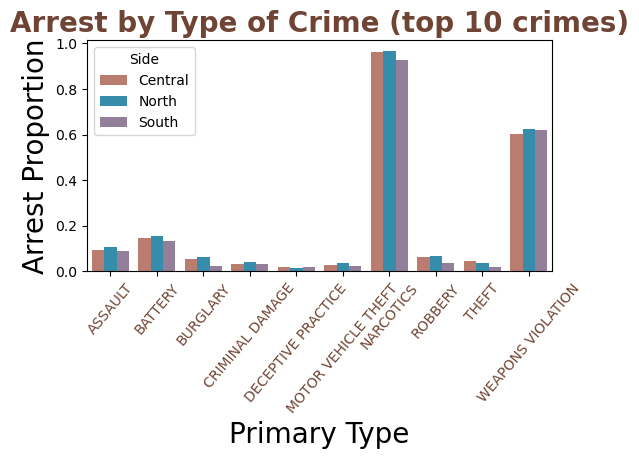

In [203]:
#| echo: false

plt.rcdefaults()
plt.rcParams["figure.figsize"] = [6,3]
colors = ["#c77464", "#2396be", "#967aa0", "#ffc858", "#d8a2e7", "#89c388", "#e6a1c6", "#6c6bc9", "#82c1c4", "#d98c55"]

sns.set_palette(sns.color_palette(colors))

top_10_crimes = arrest_data.loc[((arrest_data['Primary Type'] == 'THEFT') | \
                               (arrest_data['Primary Type'] == 'BATTERY') | \
                               (arrest_data['Primary Type'] == 'CRIMINAL DAMAGE') | \
                               (arrest_data['Primary Type'] == 'MOTOR VEHICLE THEFT') | \
                               (arrest_data['Primary Type'] == 'ASSAULT') | \
                               (arrest_data['Primary Type'] == 'DECEPTIVE PRACTICE') | \
                               (arrest_data['Primary Type'] == 'ROBBERY') | \
                               (arrest_data['Primary Type'] == 'WEAPONS VIOLATION') | \
                               (arrest_data['Primary Type'] == 'BURGLARY') | \
                               (arrest_data['Primary Type'] == 'NARCOTICS')), :]


grouped_side_type = top_10_crimes.groupby(['Side', 'Primary Type'])
grouped_side_type_m = grouped_side_type.mean().loc[:, 'Arrest']
grouped_side_type_m = grouped_side_type_m.reset_index() 

ax = sns.barplot(x='Primary Type',y='Arrest', hue='Side', data = grouped_side_type_m)
ax.set_xticklabels(ax.get_xticklabels(),rotation=50, fontdict = {
                              'color': '#704434'})
ax.set_title("Arrest by Type of Crime (top 10 crimes)",
                  fontdict = {'fontsize': 20,
                              'fontweight': 'bold',
                              'color': '#704434'})
ax.set_xlabel('Primary Type', fontsize=20)
ax.set_ylabel('Arrest Proportion', fontsize=20)

plt.show()

The barplot above shows the proportion of observations arrested for each of the 10 crimes with the most overall observances in the data, separated by the side the crime was committed in. Within this bar chart, we can see that the disparities in arrest proportion across sides prevail, though smaller in magnitude. This graph shows us that of the top 10 most frequently recorded crimes, the North Side's arrest proportion is higher for 8 of them. Additionally, we can see that some crimes have much higher arrest proportions across all sides than others: narcotics and weapons violations have higher arrest proportions than other crimes. 

I next considered the association between arrest proportion and average sentiment score for each district for the top 10 crimes. The 5 crimes of <b>Robbery</b> (0.658), <b>Battery</b> (0.598), <b>Theft</b> (0.495), <b>Assault</b> (0.459), and <b>Burglary</b> (0.442) had the highest correlation between a district's average sentiment score rating and their arrest rate (with the next highest having a correlation coefficient of 0.26). Considering comparable qualities, including arrest rate and trendline (see appendix A.1), I binned these five crimes with the highest correlations by general type (physical assualt and theft) and visualized them below.

In [204]:
#| echo: false

sentiments_arrest_dis = sentiments_2022_m.copy()
sentiments_arrest_dis = sentiments_arrest_dis.set_index('DISTRICT')

sentiments_arrest_dis['avg_sent'] = (sentiments_arrest_dis['SAFETY'] + sentiments_arrest_dis['TRUST'] + \
                                    sentiments_arrest_dis['T_RESPECT'] + sentiments_arrest_dis['T_LISTEN']) / 4
sentiments_arrest_dis = sentiments_arrest_dis.drop(columns=['SAFETY', 'TRUST', 'T_RESPECT', 'T_LISTEN'])

grouped = pd.DataFrame(top_10_crimes.groupby(['District', 'Primary Type']).mean().loc[:, 'Arrest'])

def merge_sentiments(x):
    x = pd.merge(left=x, right=sentiments_arrest_dis.reset_index(), left_on='District', right_on='DISTRICT')
    return x


grouped_new = grouped.reset_index().groupby('Primary Type').apply(merge_sentiments)


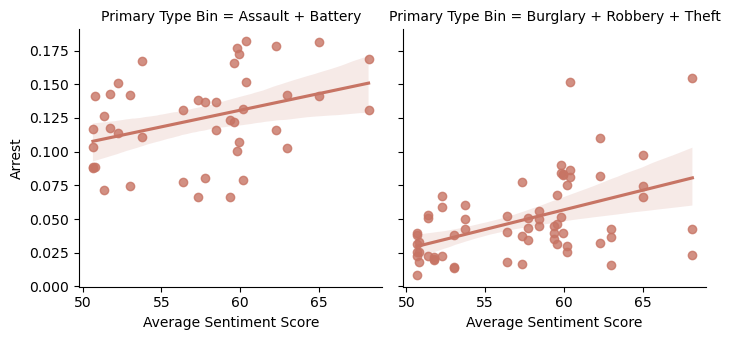

In [205]:
#| echo: false

grouped_new['Primary Type Bin'] = "None"
def bin_it(x):
    if (x['Primary Type'] == 'ASSAULT' or x['Primary Type'] == 'BATTERY'):
        x['Primary Type Bin'] = "Assault + Battery"
    elif (x['Primary Type'] == 'BURGLARY' or x['Primary Type'] == 'ROBBERY' or x['Primary Type'] == 'THEFT'):
        x['Primary Type Bin'] = "Burglary + Robbery + Theft"
    else:
        x['Primary Type Bin'] = x['Primary Type']
    return x
    
grouped_new = grouped_new.apply(bin_it, axis=1)
grouped_new = grouped_new.drop(columns = 'Primary Type')
grouped_new.reset_index()
grouped_new.groupby('Primary Type Bin')

a = sns.FacetGrid(grouped_new.loc[(grouped_new['Primary Type Bin']== 'Assault + Battery') \
                                  | (grouped_new['Primary Type Bin'] == 'Burglary + Robbery + Theft')], \
                  col = 'Primary Type Bin',col_wrap=3,height=3.5,aspect = 1)
a.map_dataframe(sns.regplot,x="avg_sent", y="Arrest")
a.set_xlabels(label='Average Sentiment Score')
plt.show()

The visualization above portrays that for the crime types that are assault and battery, as well as the crime types of burglary, robbery, and theft, there is a moderate, positive, and linear association between the proportion arrested in a district and average sentiment for a district. 

Lastly, I wanted to look at which crime-district combinations had the highest disparity in arrest proportion. Below is a dataframe displaying the top 10 most observed crime types and their districts with the highest/lowest arrest proportion, as well as the difference between the highest and lowest proportion.

In [206]:
#| echo: false
grouped = pd.DataFrame(top_10_crimes.groupby(['Primary Type', 'District']).mean().loc[:, 'Arrest'])
grouped_reset = grouped.reset_index()

disparity_df = np.ones([grouped_reset['Primary Type'].nunique(), 4])
disparity_df = pd.DataFrame(disparity_df, columns=['Primary Type', 'District of Max Arrest Proportion', \
                                                   'District of Min Arrest Proportion', 'Difference'])
disparity_df['Primary Type'] = grouped_reset['Primary Type'].value_counts().index
disparity_df = disparity_df.set_index('Primary Type')

def get_disparity(x):
    maxx = x.Arrest.max()
    minn = x.Arrest.min()
    disparity_df.loc[x.loc[x['District'] == 1, 'Primary Type'], 'District of Max Arrest Proportion'] = x.loc[x.Arrest.idxmax(), 'District']
    disparity_df.loc[x.loc[x['District'] == 1, 'Primary Type'], 'District of Min Arrest Proportion'] = x.loc[x.Arrest.idxmin(), 'District']
    disparity_df.loc[x.loc[x['District'] == 1, 'Primary Type'], 'Difference'] = maxx - minn
    
grouped_reset.groupby('Primary Type').apply(get_disparity)

disparity_df = disparity_df.reset_index()
disparity_df['Primary Type'] = disparity_df['Primary Type'].apply(lambda x: x.title())
disparity_df = disparity_df.set_index('Primary Type')
disparity_df.sort_values(by = 'Difference', ascending = False)

,District of Max Arrest Proportion,District of Min Arrest Proportion,Difference
Primary Type,,,
Weapons Violation,18.0,17.0,0.516396
Robbery,16.0,5.0,0.134063
Narcotics,19.0,6.0,0.116667
Assault,1.0,12.0,0.085086
Burglary,18.0,4.0,0.083151
Battery,1.0,7.0,0.078671
Theft,1.0,7.0,0.072987
Criminal Damage,16.0,2.0,0.036573
Deceptive Practice,22.0,25.0,0.028950


From the dataframe above (sorted by the difference in arrest proportion), we can see that, of the top 10 crimes, weapons violation has the highest arrest disparity, followed by robbery and narcotics. These top 3 all have a difference of over 10%. Additionally, 5 out of 10 of the districts with the minimum arrest proportions are on the South side of Chicago. 

## Conclusions & Recommendations

Our individual analyses answer the broader topic of how to promote personal and community safety and welfare within Chicago. This plays into people’s satisfaction with policing and how to improve these sentiments, along with suggestions on how people should look out for themselves when traveling or living in the city. When examining the various trends yielded by our analyses, it is clear that across theft, general crime, and CTA crime that rush hour and midnight are the most dangerous times. Additionally, theft is very common across Chicago, whether it be on the street, in residential homes, or transportation areas, so stakeholders should be vigilant of our possessions, and can feel less anxious about murder, for example, which only makes up 0.3% of total crimes. 

**Alyssa's recommendation** <br>
Looking overall at the types of crimes committed during the day, the main takeaway for vistors and residents of Chicago is that crime during the day is just as rampant as crime at night. Speaking on the crimes being committed, our analysis shows that the top 10 most common crimes are consistent from morning rush hour til midnight. In addition, the top 3 locations are identical for all time frames. During evening rush be especially careful because that is when the degree of public crime is highest. Note that crimes are just as public in the morning/noon as they are at midnight so do not make the assumption that you are safer when in broad daylight surrounded by many people. In addition, the analysis shows that crime is just as likely to be violent at any hour of the day. Some people like to carry personal safety equipment like pepper spray when going out at night. This equipment is just as crucial during daytime hours as it is after-dark so I advise stakeholders to take that into consideration. 

Stakeholders should keep in mind that I did not analyze every hour of the day. I am using the 8 hours that I did analyze to generalize recommendations that I believe will hold up for the other 16 hours that are not analyzed. The data we analyzed is fairly recent so stakeholders do not need to repeat my analysis. However, based on their occupation, most common commuting routes, and/or most-frequented locations, stakeholders should do extra research for their personal safety in those areas if it may differ from the analysis I've presented. Please also take a look at Grace Shao's CTA analysis if you commute via L train often.

**Grace Chang's recommendation**
<br>Next, based on the analysis of theft crimes, it is recommended to stakeholders—anyone who frequents or resides in Chicago—that they should pay more attention to their personal belongings in the region consisting of The Loop, Near North Side, Near West Side, and West Town. This region is popular for travel, as it includes financial districts and tourist attractions such as the Magnificent Mile, the Bean, and more, thus there are many stakeholders who are affected by this result. Furthermore, seeing that 33% of all thefts are thefts of financial assets over 500 dollars, and 28% are thefts of under 500 dollars, it is essential to be attentive about one’s financial possessions. Meanwhile, pick-pocketing, for example, only represents a small percentage—5.16%—of total theft crimes, so stakeholders can be assured that this crime is less common, contrary to common assumptions that pick-pocketing is a heavy concern when it comes to theft.
<br>There are a few limitations that stakeholders should keep in mind: This analysis does not include motor vehicle theft, another common type of theft, because motor vehicle theft has its own subsets of theft types that clash with the general theft category or overwhelm it, such that it became difficult to perform deeper analysis on the general theft category. Additionally, within these community areas there are neighborhoods that can vary in crime rates, but these go beyond the scope of our research and dataset, so stakeholders should do further analysis on a particular neighborhood they are visiting.

**Grace Shao's recommendation**
<br>For the CTA, it is clear that the Loop has the highest amount of crime by far. The Loop has more than 4x as much crime as the next most dangerous community area. Since the Loop is a popular tourist area, with landmarks such as the river walk, Art Institute, and Cloud Gate, many students and stakeholders may be traveling there. It is important that people stay alert when in The Loop, especially in the Roosevelt and Jackson stations. Since theft is much more likely to occur on the train than the platform, watch your belongings closely on the train. Compared to theft, physical or violent crimes have a higher chance of happening on the platform. Avoid making contact with others on the platform and leave space between you and others.

As for specific stations, avoid Roosevelt, 95th/Dan Ryan, and Jackson when possible, especially around midnight and 6-7 pm, when crime rate peaks. Chances of crime on Roosevelt are 7.68x higher than the average station. By following these recommendations, stakeholders can stay safe while traveling in the city.

**Paisley's recommendation**
<br>In regards to the police stakeholders, police should allocate resources, as well as more research into demographic information and district needs to pinpoint the roots of the disparities in arrest rates across districts for the same type of crime--namely the crimes of weapons violations in districts 17 and 18, robbery in districts 5 and 16, and narcotics in districts 6 and 19, which all have arrest proportion disparities of >10% across the named districts. 

Particularly, as seen in the associations between a district's arrest proportion and its sentiment rating, robbery has the highest correlation between a district's robbery arrest proportion and the district's police sentiment score, and also is in the top 3 crimes (of the top 10) with the highest arrest disparity. Thus, police should allocate resources to prevention of robbery in district 5, as well as further consider their arrest tactics and get community input to aim for higher sentiment scores. (Note: District 5's lowest robbery arrest proportion is followed by districts 3, 6, and 12, so this recommendation extends to these districts).

## Appendix {-}

#### A.1 - Analysis 4 reference: Associations between a district's arrest proportion for a type of crime and the district's sentiment score, top 10 crimes

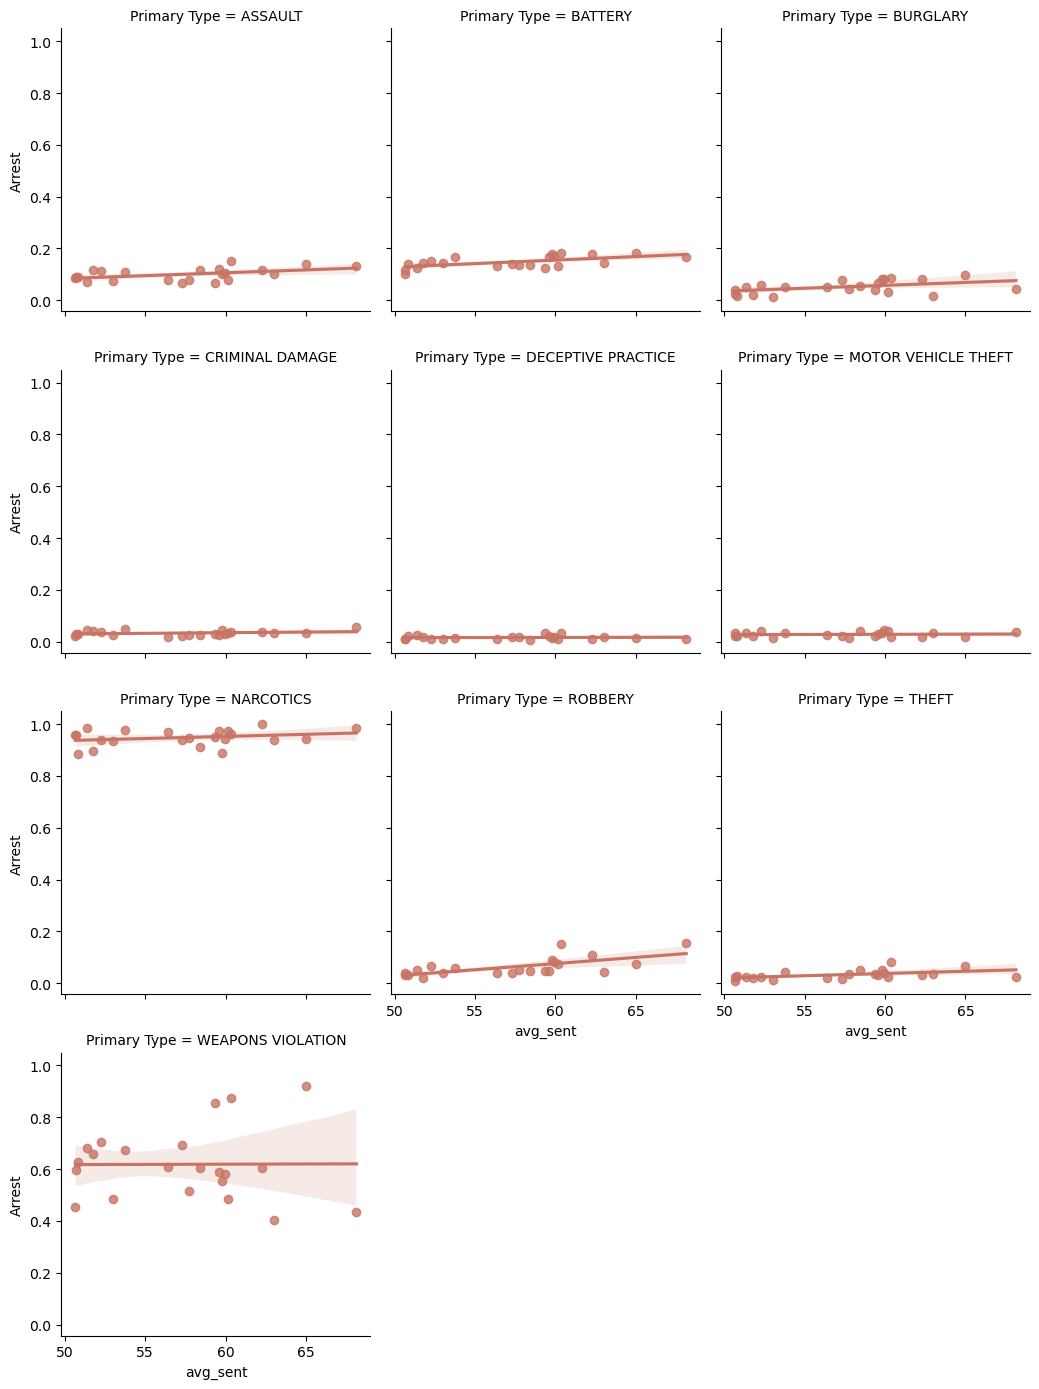

In [180]:
#| echo: false

# Group by district, type and get proportion
grouped = pd.DataFrame(top_10_crimes.groupby(['District', 'Primary Type']).mean().loc[:, 'Arrest'])

# Merge the sentiments and arrest proportions by district, apply this function on each group of primary type
def merge_sentiments(x):
    x = pd.merge(left=x, right=sentiments_arrest_dis.reset_index(), left_on='District', right_on='DISTRICT')
    return x


grouped_new = grouped.reset_index().groupby('Primary Type').apply(merge_sentiments)

# Plot
a = sns.FacetGrid(grouped_new, \
                  col = 'Primary Type',col_wrap=3,height=3.5,aspect = 1)
a.map_dataframe(sns.regplot,x="avg_sent", y="Arrest")
plt.show()

#### A.2 - Comparison to previous project on Chicago crime

Previous year's analysis on the types of crime throughout the day focused on specific community areas that Northwestern students frequently visit. They also found a peak in number of crimes at 12 am and 12 pm. Our analysis is more general and analyzed crimes in all areas at peak times.

Previous year's CTA findings: While the previous year did not analyze all of the stations, they did single out Howard station as one of interest, given that students used it frequently. They found that crime on Howard peaked just after midnight and around rush hour, which matches with the analysis I did on the top 3 most dangerous stations. In those stations, the most dangerous times were also around 1-2 AM and rush hour.